In [1]:
import pandas as pd

df = pd.read_csv("project-2-at-2025-09-12-06-46-b36c7e7f.csv")
print(df.columns)


Index(['annotation_id', 'annotator', 'comentario', 'created_at', 'data', 'id',
       'lead_time', 'motivo', 'score', 'updated_at'],
      dtype='object')


In [ ]:
import pandas as pd
import os

# CSV con anotaciones
df = pd.read_csv("project-2-at-2025-09-12-06-46-b36c7e7f.csv")

# Carpeta con imágenes del zip YOLOv8
img_dir = "dataset/train/images"

df["filename"] = df["data"].apply(lambda x: os.path.basename(x))
print(df["filename"])
# Verificar que cada imagen exista en la carpeta exportada
df["exists"] = df["filename"].apply(lambda x: os.path.exists(os.path.join(img_dir, x)))

print(df.head())
print("Imágenes encontradas:", df["exists"].sum(), "/", len(df))


0      8bb62781-13_jpg.rf.47f03fb9cb7dc92fcbd7556f125...
1      7a51d475-31_jpg.rf.da60e32e87c945655a94de208c4...
2      127c1049-32_jpg.rf.fd34c321719acdc0163b0905ee4...
3      7d24e4a4-59_jpg.rf.498bc52c0adead1b2e02014d786...
4      c1e8cd34-86_jpg.rf.0b458aabd7010ee338124855cbf...
                             ...                        
192    218af4a7-images-2023-05-30T190049-158_jpg.rf.6...
193    812ecf6e-images-2023-05-30T190049-181_jpg.rf.8...
194    7fbfd96e-images-2023-05-30T190049-185_jpg.rf.7...
195    44b1631e-images-2023-05-30T190049-208_jpg.rf.d...
196    0081ca6d-italiano_jpeg.rf.993dc0ab9b9126553660...
Name: filename, Length: 197, dtype: object
   annotation_id  annotator  comentario                   created_at  \
0              4          1         NaN  2025-09-12T03:31:53.514237Z   
1              5          1         NaN  2025-09-12T03:32:10.625150Z   
2              6          1         NaN  2025-09-12T03:32:16.742523Z   
3              7          1         NaN  2

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Dividir en train (80%), valid (10%), test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(len(train_df), len(valid_df), len(test_df))


157 20 20


In [4]:
df["filename"] 

0      8bb62781-13_jpg.rf.47f03fb9cb7dc92fcbd7556f125...
1      7a51d475-31_jpg.rf.da60e32e87c945655a94de208c4...
2      127c1049-32_jpg.rf.fd34c321719acdc0163b0905ee4...
3      7d24e4a4-59_jpg.rf.498bc52c0adead1b2e02014d786...
4      c1e8cd34-86_jpg.rf.0b458aabd7010ee338124855cbf...
                             ...                        
192    218af4a7-images-2023-05-30T190049-158_jpg.rf.6...
193    812ecf6e-images-2023-05-30T190049-181_jpg.rf.8...
194    7fbfd96e-images-2023-05-30T190049-185_jpg.rf.7...
195    44b1631e-images-2023-05-30T190049-208_jpg.rf.d...
196    0081ca6d-italiano_jpeg.rf.993dc0ab9b9126553660...
Name: filename, Length: 197, dtype: object

In [5]:
from ultralytics import YOLO
import os
from PIL import Image
import pandas as pd
import numpy as np

best_pt = r"C:\Users\anays\OneDrive\Escritorio\shefu_vc\shefu\runs_detector1\rf_completos22\weights\best.pt"  # tu detector
yolo = YOLO(best_pt)
yolo.to("cpu")   
crop_dir = "dataset/crops"
os.makedirs(crop_dir, exist_ok=True)

def crop_one(fn):
    src = os.path.join(img_dir, fn)
    if not os.path.exists(src):
        return None
    # detecta
    r = yolo(src, imgsz=640, conf=0.25, verbose=False)[0]
    if r.boxes is None or len(r.boxes) == 0:
        return None
    # elige la bbox con mayor confianza
    i = int(r.boxes.conf.argmax().cpu().numpy())
    x1, y1, x2, y2 = map(int, r.boxes.xyxy[i].cpu().numpy())

    im = Image.open(src).convert("RGB")
    w, h = im.size
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    if x2 <= x1 or y2 <= y1:
        return None

    crop = im.crop((x1, y1, x2, y2))
    out_fn = f"crop_{fn}"
    crop.save(os.path.join(crop_dir, out_fn), quality=95)
    return out_fn

# genera nombre de archivo recortado por fila
df["crop_filename"] = df["filename"].apply(crop_one)

# quita filas donde YOLO no encontró completo
df_crops = df.dropna(subset=["crop_filename"]).reset_index(drop=True)
df_crops.to_csv("regression_crops.csv", index=False)

print("Recortes listos:", len(df_crops), "Guardados en:", crop_dir)


WARNING Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\anays\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Recortes listos: 193 Guardados en: dataset/crops


In [6]:
import torch
import math

class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, path="checkpoints/best_model.pth"):
        """
        patience: nº de épocas a esperar sin mejora antes de detener
        delta: mejora mínima para considerar que hubo progreso
        path: ruta donde guardar el mejor modelo
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_loss = math.inf
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)  # guarda mejor modelo
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
# =========================================================
# RECORTE (YOLO) + REGRESIÓN
# =========================================================
import os
import ast
import math
import random
import pandas as pd
from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

from ultralytics import YOLO


# CONFIG

CSV_PATH      = "project-2-at-2025-09-12-06-46-b36c7e7f.csv"  # CSV original exportado de Label Studio
IMG_DIR       = "dataset/train/images"        # carpeta con imágenes originales
CROP_DIR      = "dataset/crops"               # carpeta donde guardaremos recortes
CROPS_CSV_OUT = "regression_crops.csv"        # CSV nuevo con 'crop_filename' + 'score_clean'

# Entrenamiento
BATCH_SIZE = 16
NUM_EPOCHS = 30
LR         = 1e-4
IMG_SIZE   = 224
SEED       = 42

YOLO_WEIGHTS = r"C:\Users\anays\OneDrive\Escritorio\shefu_vc\shefu\runs_detector1\rf_completos22\weights\best.pt" 
YOLO_IMGSZ   = 640
YOLO_CONF    = 0.25
PAD_RATIO    = 0.05   # padding relativo alrededor de la bbox (5%)


# Utils

def set_seed(s=SEED):
    random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)

def clean_score_cell(x):
    """Convierte '[{"number":90}]' -> 90.0; si ya es número, lo castea."""
    try:
        data = ast.literal_eval(x)
        if isinstance(data, list) and len(data) > 0 and isinstance(data[0], dict) and "number" in data[0]:
            return float(data[0]["number"])
        return float(x)
    except Exception:
        return None

def ensure_dir(d):
    Path(d).mkdir(parents=True, exist_ok=True)


# 1) Cargar + limpiar CSV

set_seed()
ensure_dir(CROP_DIR)

df = pd.read_csv(CSV_PATH)

if "filename" not in df.columns:
    df["filename"] = df["data"].apply(lambda x: os.path.basename(str(x)))

# limpiar score
df["score_clean"] = df["score"].apply(clean_score_cell)
df = df.dropna(subset=["score_clean"]).reset_index(drop=True)

print("Dataset con score limpio:", len(df))
print(df[["filename", "score", "score_clean"]].head())


# 2) Pre-recortar con YOLO

yolo = YOLO(YOLO_WEIGHTS)
yolo.to("cpu") 

def crop_with_yolo(fn, out_dir=CROP_DIR):
    """Devuelve nombre del recorte guardado o None si no detecta."""
    src = os.path.join(IMG_DIR, fn)
    if not os.path.exists(src):
        return None
    # Inferencia
    r = yolo(src, imgsz=YOLO_IMGSZ, conf=YOLO_CONF, verbose=False)[0]
    if r.boxes is None or len(r.boxes) == 0:
        return None

    # Seleccionar la bbox con mayor confianza
    i = int(r.boxes.conf.argmax().cpu().numpy())
    x1, y1, x2, y2 = map(int, r.boxes.xyxy[i].cpu().numpy())

    # Padding relativo
    with Image.open(src).convert("RGB") as im:
        W, H = im.size
        pad_x = int(PAD_RATIO * (x2 - x1))
        pad_y = int(PAD_RATIO * (y2 - y1))
        x1p = max(0, x1 - pad_x); y1p = max(0, y1 - pad_y)
        x2p = min(W, x2 + pad_x); y2p = min(H, y2 + pad_y)
        if x2p <= x1p or y2p <= y1p:
            return None

        crop = im.crop((x1p, y1p, x2p, y2p))
        # Nombre de salida
        stem = Path(fn).stem
        out_name = f"{stem}_crop.jpg"
        out_path = os.path.join(out_dir, out_name)
        crop.save(out_path, quality=95)
        return out_name

print("Generando recortes con YOLO (esto puede tardar un poco)...")
df["crop_filename"] = df["filename"].apply(crop_with_yolo)

# Filtrar filas sin recorte
df_crops = df.dropna(subset=["crop_filename"]).reset_index(drop=True)
df_crops.to_csv(CROPS_CSV_OUT, index=False)
print(f"Recortes listos: {len(df_crops)} | CSV guardado en: {CROPS_CSV_OUT} | Carpeta recortes: {CROP_DIR}")

if len(df_crops) < 10:
    print("⚠️ Muy pocos recortes detectados. Considera bajar YOLO_CONF o revisar el detector.")


# 3) Dataset de recortes

class CompletoDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, fname_col="crop_filename"):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.fname_col = fname_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row[self.fname_col])
        with Image.open(img_path).convert("RGB") as image:
            if self.transform:
                image = self.transform(image)
        score = float(row["score_clean"]) / 100.0  # 0..1
        return image, torch.tensor([score], dtype=torch.float32)


# 4) Split + DataLoaders

train_df, temp_df = train_test_split(df_crops, test_size=0.2, random_state=SEED)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms().mean,
                         std=MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms().std),
])

valid_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms().mean,
                         std=MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms().std),
])

train_ds = CompletoDataset(train_df, CROP_DIR, transform=train_tfms)
valid_ds = CompletoDataset(valid_df, CROP_DIR, transform=valid_tfms)
test_ds  = CompletoDataset(test_df,  CROP_DIR, transform=valid_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,      num_workers=0,             
    pin_memory=False,           
    persistent_workers=False   
)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,     num_workers=0,             
    pin_memory=False,
    persistent_workers=False   
)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,     num_workers=0,             
    pin_memory=False,           
    persistent_workers=False   
)

print(f"Split: {len(train_ds)} train | {len(valid_ds)} valid | {len(test_ds)} test")


# 5) Modelo (MobileNetV3 + Sigmoid)

device = torch.device("cpu")

weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = mobilenet_v3_small(weights=weights)
# Reemplazar cabeza por regresión en [0,1]
in_f = model.classifier[3].in_features
model.classifier[3] = nn.Sequential(
    nn.Linear(in_f, 1),
    nn.Sigmoid()
)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


# 6) Entrenamiento

history = {"train_loss": [], "val_loss": []}
best_val = math.inf
os.makedirs("checkpoints", exist_ok=True)

patience = 5           # nº de épocas a esperar sin mejora
counter = 0            # cuántas épocas seguidas sin mejora
best_val = math.inf    


for epoch in range(NUM_EPOCHS):
    
    # Train
    
    model.train()
    tr_loss = 0.0
    for imgs, scores in train_loader:
        imgs, scores = imgs.to(device), scores.to(device)
        preds = model(imgs)
        loss = criterion(preds, scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * imgs.size(0)
    tr_loss /= len(train_loader.dataset)

    
    # Validation
    
    model.eval()
    va_loss = 0.0
    with torch.no_grad():
        for imgs, scores in valid_loader:
            imgs, scores = imgs.to(device), scores.to(device)
            preds = model(imgs)
            loss = criterion(preds, scores)
            va_loss += loss.item() * imgs.size(0)
    va_loss /= len(valid_loader.dataset)

    
    # Logging
    
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)

    print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | Train {tr_loss:.4f} | Val {va_loss:.4f}")

    
    # Check for improvement (Early Stopping)
    
    if va_loss < best_val - 1e-4:   # delta = mejora mínima
        best_val = va_loss
        counter = 0
        torch.save(model.state_dict(), "checkpoints/best_model.pth")
        print("Mejor modelo actualizado")
    else:
        counter += 1
        print(f"No mejora en validación ({counter}/{patience})")

    if counter >= patience:
        print("Early stopping activado: no hay mejoras en validación")
        break

print(" Entrenamiento terminado. Mejor modelo en checkpoints/best_model.pth")



import numpy as np
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, scores in test_loader:
        imgs = imgs.to(device)
        preds = model(imgs).cpu().numpy().flatten()
        y_pred.extend(preds * 100.0)
        y_true.extend(scores.numpy().flatten() * 100.0)

y_true, y_pred = np.array(y_true), np.array(y_pred)
mae  = float(np.mean(np.abs(y_true - y_pred))) if len(y_true) else float("nan")
rmse = float(np.sqrt(np.mean((y_true - y_pred)**2))) if len(y_true) else float("nan")
print(f"Test MAE: {mae:.2f} | RMSE: {rmse:.2f} (escala 0–100)")


Dataset con score limpio: 196
                                            filename            score  \
0  8bb62781-13_jpg.rf.47f03fb9cb7dc92fcbd7556f125...  [{"number":60}]   
1  7a51d475-31_jpg.rf.da60e32e87c945655a94de208c4...  [{"number":85}]   
2  127c1049-32_jpg.rf.fd34c321719acdc0163b0905ee4...  [{"number":85}]   
3  7d24e4a4-59_jpg.rf.498bc52c0adead1b2e02014d786...  [{"number":50}]   
4  c1e8cd34-86_jpg.rf.0b458aabd7010ee338124855cbf...  [{"number":20}]   

   score_clean  
0         60.0  
1         85.0  
2         85.0  
3         50.0  
4         20.0  
Generando recortes con YOLO (esto puede tardar un poco)...
Recortes listos: 192 | CSV guardado en: regression_crops.csv | Carpeta recortes: dataset/crops
Split: 153 train | 19 valid | 20 test
Epoch 01/30 | Train 0.0693 | Val 0.0522
Mejor modelo actualizado
Epoch 02/30 | Train 0.0577 | Val 0.0558
No mejora en validación (1/5)
Epoch 03/30 | Train 0.0472 | Val 0.0472
Mejor modelo actualizado
Epoch 04/30 | Train 0.0401 | Val 0.04

In [8]:
print(df["score_clean"].isna().sum())
print(df[df["score_clean"].isna()])


0
Empty DataFrame
Columns: [annotation_id, annotator, comentario, created_at, data, id, lead_time, motivo, score, updated_at, filename, score_clean, crop_filename]
Index: []


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Cargar mejor modelo
model.load_state_dict(torch.load("checkpoints/best_model.pth", map_location=device))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for imgs, scores in test_loader:
        imgs, scores = imgs.to(device), scores.to(device)
        preds = model(imgs).cpu().numpy().flatten()
        scores = scores.cpu().numpy().flatten()

        # volver a escala 0–100
        y_pred.extend(preds * 100)
        y_true.extend(scores * 100)

y_true, y_pred = np.array(y_true), np.array(y_pred)

# Métricas
mae = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

print(f"MAE: {mae:.2f} puntos | RMSE: {rmse:.2f} puntos")


MAE: 11.34 puntos | RMSE: 14.30 puntos


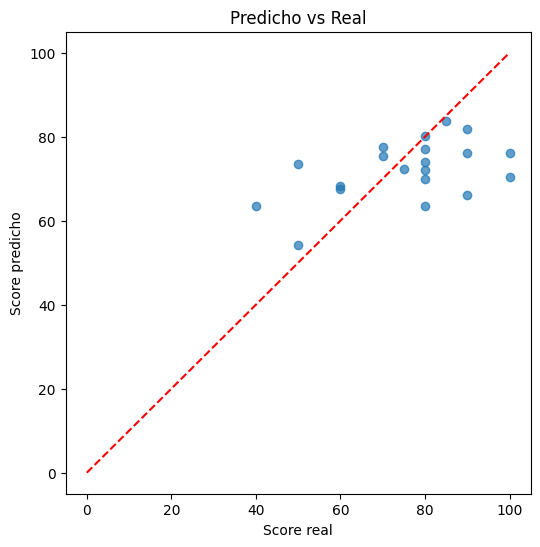

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([0,100], [0,100], 'r--')  # línea ideal
plt.xlabel("Score real")
plt.ylabel("Score predicho")
plt.title("Predicho vs Real")
plt.show()


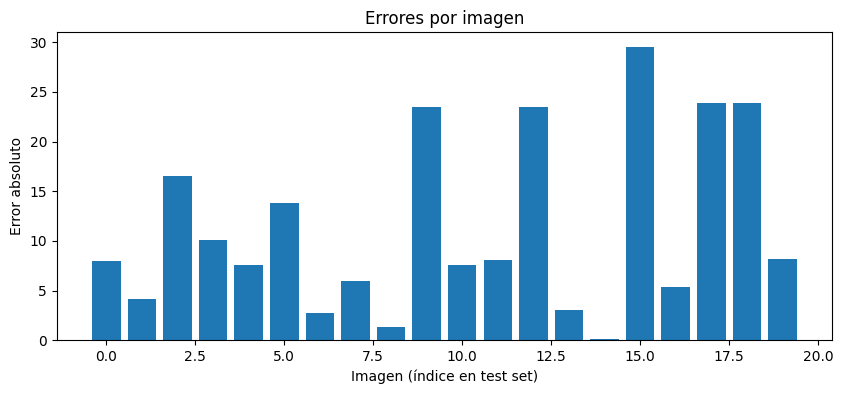

In [11]:
errors = np.abs(y_true - y_pred)

plt.figure(figsize=(10,4))
plt.bar(range(len(errors)), errors)
plt.xlabel("Imagen (índice en test set)")
plt.ylabel("Error absoluto")
plt.title("Errores por imagen")
plt.show()


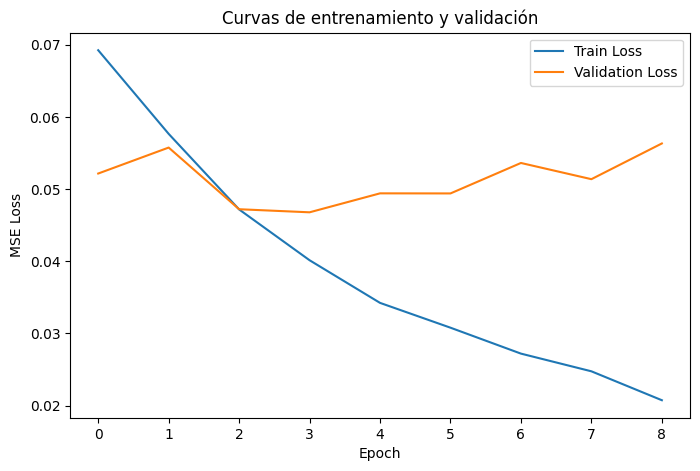

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Curvas de entrenamiento y validación")
plt.legend()
plt.show()


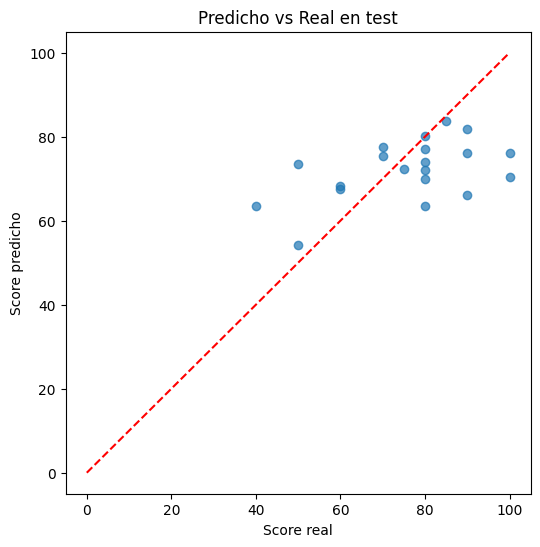

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([0,100], [0,100], "r--")
plt.xlabel("Score real")
plt.ylabel("Score predicho")
plt.title("Predicho vs Real en test")
plt.show()


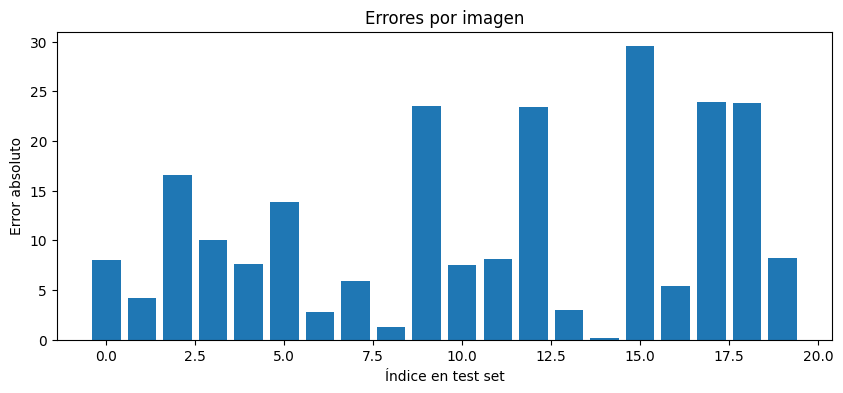

In [14]:
errors = abs(y_true - y_pred)

plt.figure(figsize=(10,4))
plt.bar(range(len(errors)), errors)
plt.xlabel("Índice en test set")
plt.ylabel("Error absoluto")
plt.title("Errores por imagen")
plt.show()


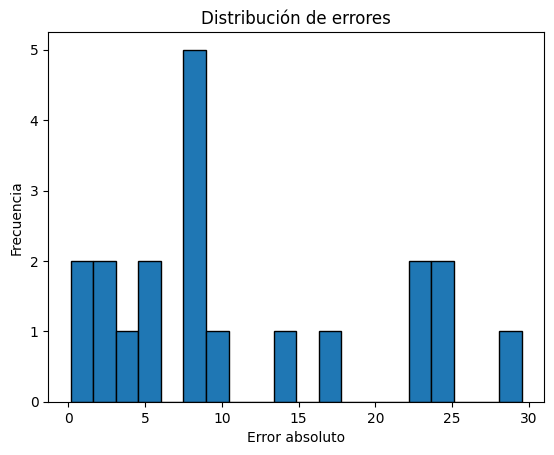

In [15]:
plt.hist(errors, bins=20, edgecolor="black")
plt.xlabel("Error absoluto")
plt.ylabel("Frecuencia")
plt.title("Distribución de errores")
plt.show()


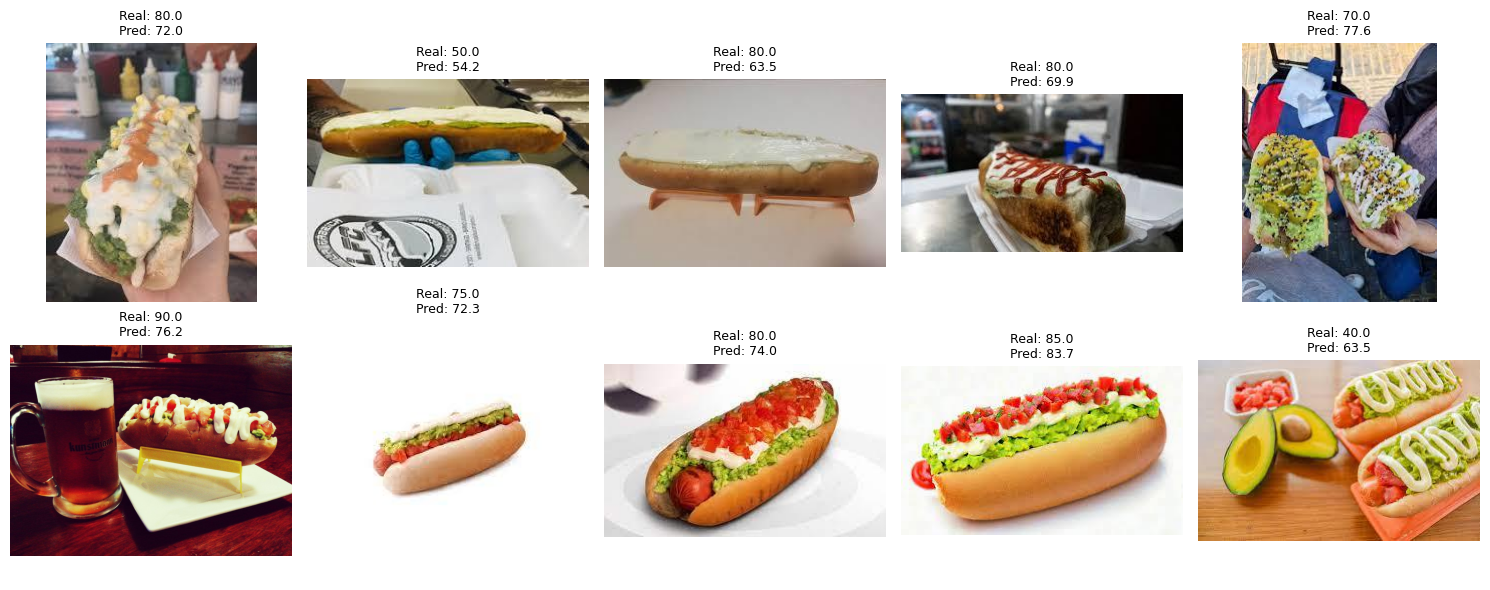

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

n = 10  
cols = 5
rows = (n + cols - 1) // cols  # calcula filas necesarias

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

for i in range(n):
    img_path = os.path.join("dataset/train/images", df.iloc[i]["filename"])
    img = Image.open(img_path)

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Real: {y_true[i]:.1f}\nPred: {y_pred[i]:.1f}", fontsize=9)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch

from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import torch.nn as nn

weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = mobilenet_v3_small(weights=weights)
in_f = model.classifier[3].in_features
model.classifier[3] = nn.Sequential(
    nn.Linear(in_f, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load("checkpoints/best_model.pth", map_location="cpu"))
model.eval()

# Dummy input (batch_size=1, 3 canales, 224x224)
dummy_input = torch.randn(1, 3, 224, 224)

# Exportar a ONNX
torch.onnx.export(
    model,
    dummy_input,
    "completos_model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
    opset_version=13
)
print("✅ Exportado a ONNX: completos_model.onnx")


AttributeError: cannot import name 'float4_e2m1fn' from 'ml_dtypes'

In [ ]:
import onnxruntime as ort
import numpy as np

ort_session = ort.InferenceSession("completos_model.onnx")
dummy = np.random.randn(1, 3, 224, 224).astype(np.float32)
outputs = ort_session.run(None, {"input": dummy})
print("ONNX output:", outputs[0])


ONNX output: [[    0.49433]]


In [ ]:
import os
print("Existe:", os.path.exists("completos_model.onnx"))
print("Tamaño (bytes):", os.path.getsize("completos_model.onnx"))
import subprocess, sys

cmd = [sys.executable, "-m", "onnx2tf",
    "-i", "completos_model.onnx",
    "-o", "shefu_tf",
    "--disable_ai_edge_litert",
    "--non_verbose"]
result = subprocess.run(cmd, capture_output=True, text=True)
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)



Existe: True
Tamaño (bytes): 6090104
🔴 STDOUT:
 
🔴 STDERR:
 Traceback (most recent call last):
  File "c:\Users\anays\OneDrive\Escritorio\shefu_vc\shefu\yolov8\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 70, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: %1 no es una aplicaciÃ³n Win32 vÃ¡lida.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\anays\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 187, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "C:\Users\anays\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 146, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "C:\Users\anays\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 110, in _get_module_details
    __import__(pkg_nam

In [ ]:

import os, sys, subprocess, tensorflow as tf

onnx_path = "completos_model.onnx"
tf_dir = "shefu_tf"
tflite_path = "completos_model.tflite"

print("Verificando dependencias...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "onnx2tf", "onnx_graphsurgeon"])

print(f"Convirtiendo {onnx_path} → {tf_dir}/ ...")

cmd = [
    sys.executable, "-m", "onnx2tf",
    "-i", "completos_model.onnx",
    "-o", "shefu_tf",
    "--disable_ai_edge_litert",
    "--non_verbose"
]
subprocess.run(cmd, check=True)

print(" Exportando a TFLite...")
converter = tf.lite.TFLiteConverter.from_saved_model(tf_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print(f" Conversión completa: {tflite_path}")


Verificando dependencias...
Convirtiendo completos_model.onnx → shefu_tf/ ...


CalledProcessError: Command '['c:\\Users\\anays\\OneDrive\\Escritorio\\shefu_vc\\shefu\\yolov8\\Scripts\\python.exe', '-m', 'onnx2tf', '-i', 'completos_model.onnx', '-o', 'shefu_tf', '--disable_ai_edge_litert', '--non_verbose']' returned non-zero exit status 1.

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("shefu_tf")
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Opcional: reducir tamaño
tflite_model = converter.convert()

with open("shefu_model.tflite", "wb") as f:
    f.write(tflite_model)

print(" Modelo TFLite guardado en shefu_model.tflite")


OSError: SavedModel file does not exist at: shefu_tf\{saved_model.pbtxt|saved_model.pb}